In [1]:
import json
import os
import pickle

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import scipy.misc
from scipy import ndimage
from sklearn.externals import joblib
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model, model_from_json
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import CustomObjectScope

In [2]:
def get_models_paths(folder):
    files = os.listdir(folder)
    files.sort()
    files = ["{}/{}".format(folder, file) for file in files if not file.startswith(".")]
    return files

In [44]:
models_json = get_models_paths("trained_model_files/angles/JSON")
print("\n".join("{}: {}".format(*k) for k in enumerate(models_json)))

0: trained_model_files/angles/JSON/TMA.json
1: trained_model_files/angles/JSON/TMA_v10_DI_PA_different_neurons_Adagrad_30_.json
2: trained_model_files/angles/JSON/TMA_v11_DI_PA_different_neurons_Adadelta_2.3_.json
3: trained_model_files/angles/JSON/TMA_v12_DI_PA_different_neurons_Adamax_47_.json
4: trained_model_files/angles/JSON/TMA_v13_DI_PA_different_neurons_Nadam_0.2_.json
5: trained_model_files/angles/JSON/TMA_v14_DI_PA_different_neurons_RMSProp_35_.json
6: trained_model_files/angles/JSON/TMA_v15_DI_PA_different_neurons_SGD_26_.json
7: trained_model_files/angles/JSON/TMA_v16_DI_PA_different_neurons_and_layouts_4Conv_53_.json
8: trained_model_files/angles/JSON/TMA_v17_DI_PA_different_neurons_and_layouts_4Conv_differentFM_63_.json
9: trained_model_files/angles/JSON/TMA_v18_DI_PA_DN_and_L_PM_VGG16_20.15_.json
10: trained_model_files/angles/JSON/TMA_v19_DI_PA_DN_and_L_PM_VGG19_16.04_.json
11: trained_model_files/angles/JSON/TMA_v2.json
12: trained_model_files/angles/JSON/TMA_v20_DI_PA

In [43]:
models_h5 = get_models_paths("trained_model_files/angles/H5")
# print("\n".join("{}: {}".format(*k) for k in enumerate(models_h5)))

In [45]:
CATEGORIES_INT = [i for i in range(1, 361)]
CATEGORIES = [str(item) for item in CATEGORIES_INT]
# map(str, CATEGORIES)
# print(CATEGORIES)

In [6]:
def prepare_1ch(filepath):
    IMG_SIZE = 100  # 50 in txt-based
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    img_array = img_array / 255
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [8]:
def prepare_3ch(filepath):
    IMG_SIZE = 100  # 50 in txt-based
    img_array = cv2.imread(filepath)
    img_array = img_array / 255
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [307]:
index_to_model = 28
json_file = open(models_json[index_to_model], "r")
loaded_model_json = json_file.read()
json_file.close()
# loaded_model = model_from_json(loaded_model_json, custom_objects={'BatchNormalizationV1': BatchNormalizationV1()})
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(models_h5[index_to_model])
loaded_model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

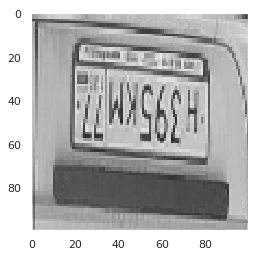

In [520]:
img_path = "/home/apofeo/Documents/CropNumbers/H395KM 77 (copy).png"
# img_path = "/home/apofeo/Documents/clp_rotated_test/train/200/bab717de49084b2a91e3fe2d3f272db3.png"
# img_path = "/home/apofeo/Documents/clp_rotated_v7/test/148/5d98d2923894428d9dd6591d174d926e.png"
# img_path = "im_base_to_angle/rotated_5_pa/test/59/04863e7d13d4462aaaafd675eeaf3170.png"
# img_path = "/home/apofeo/Documents/Screenshot from 2019-03-20 23-39-04.png"
img = image.load_img(img_path, target_size=(100, 100))
# img = ndimage.rotate(img, 180, reshape=True)
plt.grid(False)
plt.imshow(img)

In [521]:
prediction = loaded_model.predict(prepare_3ch(img_path))
# print(prediction)

In [522]:
print(f'{np.argmax(prediction)} ({CATEGORIES[np.argmax(prediction)]})')

179 (180)


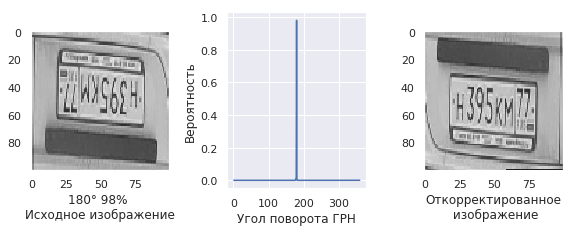

In [523]:
# grid = plt.GridSpec(1, 2, wspace=0.8, hspace=0.3)
# fig, axs = plt.subplots(1,2,figsize=(10,5))
# fig.subplots_adjust(hspace=0.4, wspace=0.5)
fig = plt.figure(figsize=(8, 6))
d = {"Угол поворота ГРН": CATEGORIES_INT, "Вероятность": prediction[0]}
pdnumval = pd.DataFrame(d)
plt.subplot2grid((2, 6), (0, 0),colspan=2)
plt.imshow(img)
plt.grid(False)
plt.xlabel(
        "{}\N{DEGREE SIGN} {:2.0f}% \nИсходное изображение".format(
            CATEGORIES[np.argmax(prediction)],
            100 * np.max(prediction)
        )
)
plt.subplot2grid((2, 6), (0, 2), colspan=2)
sns.set(style="darkgrid")
sns.lineplot(x="Угол поворота ГРН", y="Вероятность", data=pdnumval)

result_angle = int(CATEGORIES[np.argmax(prediction)])
img_result = ndimage.rotate(img, -result_angle, reshape=False)
plt.subplot2grid((2, 6), (0, 4), colspan=2)
plt.grid(False)
plt.imshow(img_result)
plt.xlabel("Откорректированное\n изображение")
plt.tight_layout(pad=0.6, w_pad=0.7, h_pad=1.0)

In [515]:
# result_angle = int(CATEGORIES[np.argmax(prediction)])
# img_result = ndimage.rotate(img, -result_angle, reshape=False)
# plt.grid(False)
# plt.imshow(img_result)

#### Dirty imgs for test

In [172]:
filename = "trained_data/X_4_di_pa_3ch_test.sav"
X = joblib.load(filename)
# print(X[2])
# pickle_in = open("trained_data/X_4_di_pa.pickle","rb")
# X = pickle.load(pickle_in)

In [173]:
filename = "trained_data/y_4_di_pa_3ch_test.sav"
y = joblib.load(filename)
# pickle_in = open("trained_data/y_4_di_pa.pickle","rb")
# y = pickle.load(pickle_in)

In [174]:
filename = "trained_data/Z_4_di_pa_3ch_test.sav"
Z = joblib.load(filename)
# pickle_in = open("trained_data/y_4_di_pa.pickle","rb")
# y = pickle.load(pickle_in)

#### Clean imgs for test

In [9]:
filename = "trained_data/X_CI_pa_3ch_test.sav"
X_CI = joblib.load(filename)

In [10]:
filename = "trained_data/Y_CI_pa_3ch_test.sav"
Y_CI = joblib.load(filename)

In [11]:
filename = "trained_data/Z_CI_pa_3ch_test.sav"
Z_CI = joblib.load(filename)

#### Training set (dirty imgs)

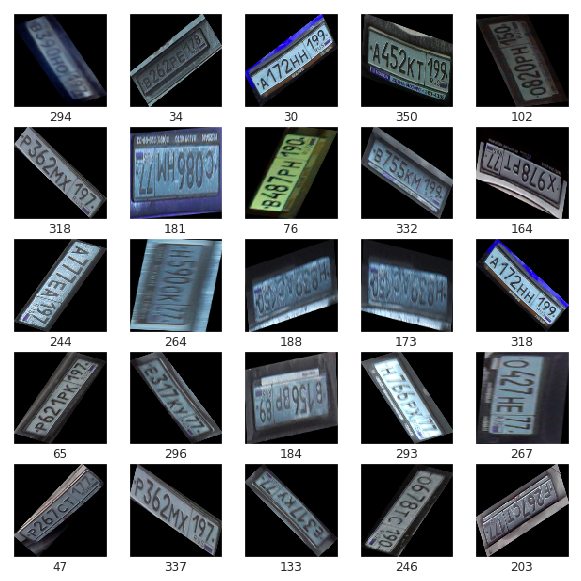

In [45]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i], cmap=plt.cm.binary)
    plt.xlabel(y[i])
plt.show()

#### Test set (dirty imgs)

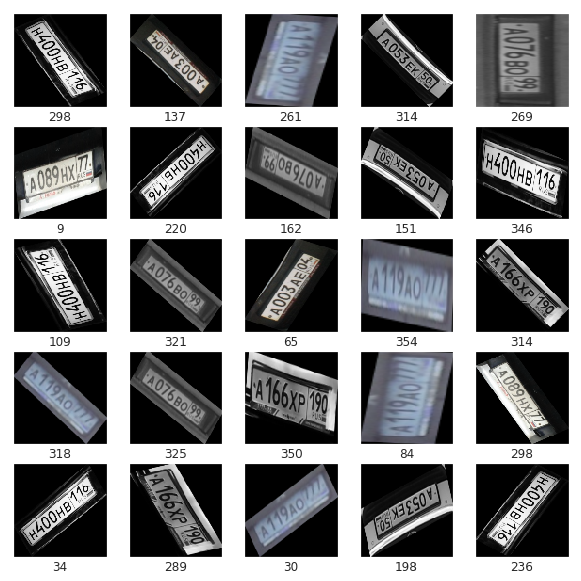

In [175]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i], cmap=plt.cm.binary)
    plt.xlabel(y[i])
plt.show()

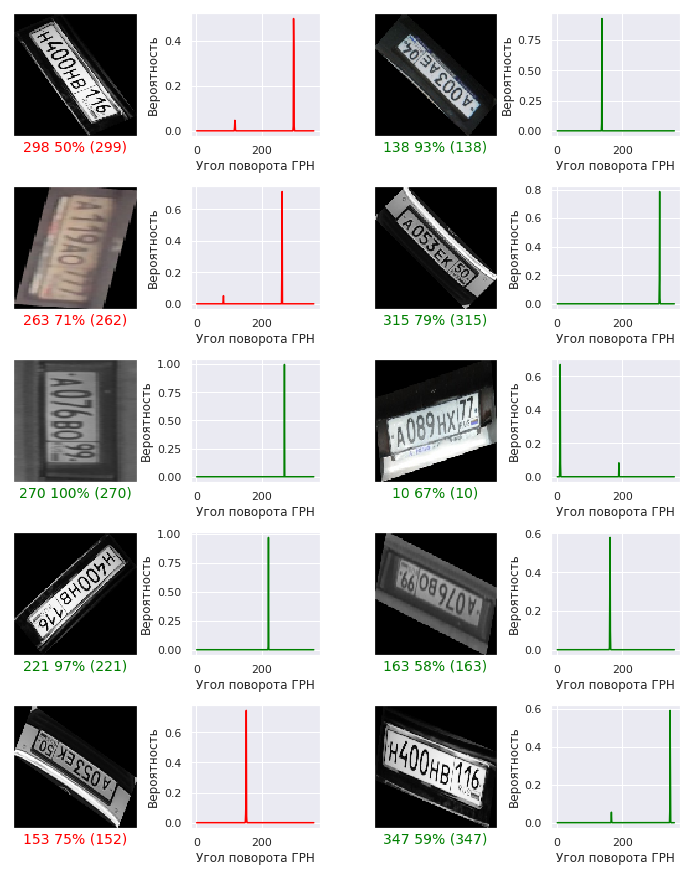

In [255]:
num_rows = 5
num_cols = 2
num_images = num_rows*num_cols
fig = plt.figure(figsize=(6*num_cols, 3*num_rows))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for idx, path in enumerate(Z[:num_images]):
    prediction = loaded_model.predict(prepare(path))
    img = image.load_img(path, target_size=(100, 100))
#     fig = plt.figure(figsize=(8, 6))
    d = {"Угол поворота ГРН": CATEGORIES_INT, "Вероятность": prediction[0]}
    pdnumval = pd.DataFrame(d)
    fig.add_subplot(num_rows, 2*num_cols, 2*idx+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    predicted_label = np.argmax(prediction)
    if predicted_label == y[idx]:
        color = "green"
    else:
        color = "red"
    plt.xlabel(
            "{} {:2.0f}% ({})".format(
                CATEGORIES[predicted_label],
                100 * np.max(prediction),
                CATEGORIES[y[idx]],
            ),
        color = color,
        fontsize = 14
    )
    fig.add_subplot(num_rows, 2*num_cols, 2*idx+2)
    sns.set(style="darkgrid")
    sns.lineplot(x="Угол поворота ГРН", y="Вероятность", data=pdnumval, color=color)

#### Test set (clean imgs)

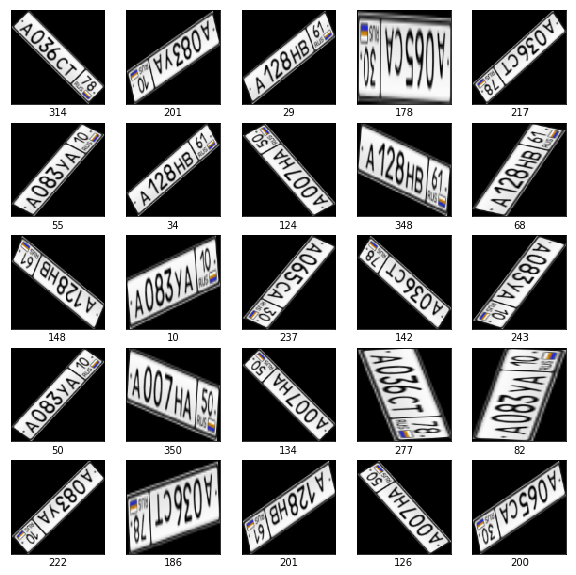

In [12]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_CI[i], cmap=plt.cm.binary)
    plt.xlabel(Y_CI[i])
plt.show()

#### Test prediction on clean imgs

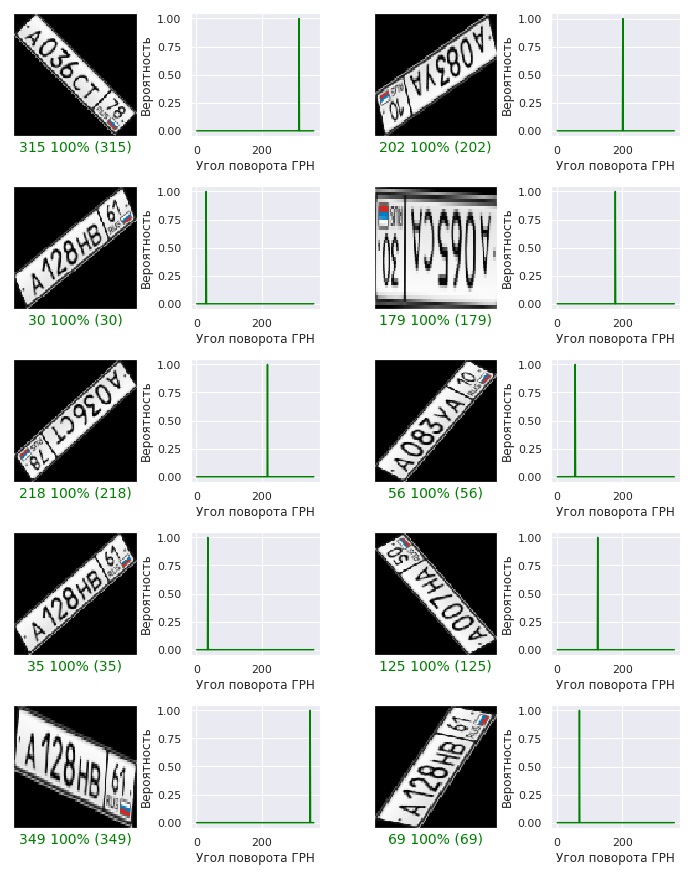

In [14]:
num_rows = 5
num_cols = 2
num_images = num_rows*num_cols
fig = plt.figure(figsize=(6*num_cols, 3*num_rows))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for idx, path in enumerate(Z_CI[:num_images]):
    prediction = loaded_model.predict(prepare(path))
    img = image.load_img(path, target_size=(100, 100))
#     fig = plt.figure(figsize=(8, 6))
    d = {"Угол поворота ГРН": CATEGORIES_INT, "Вероятность": prediction[0]}
    pdnumval = pd.DataFrame(d)
    fig.add_subplot(num_rows, 2*num_cols, 2*idx+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    predicted_label = np.argmax(prediction)
    if predicted_label == Y_CI[idx]:
        color = "green"
    else:
        color = "red"
    plt.xlabel(
            "{} {:2.0f}% ({})".format(
                CATEGORIES[predicted_label],
                100 * np.max(prediction),
                CATEGORIES[Y_CI[idx]],
            ),
        color = color,
        fontsize = 14
    )
    fig.add_subplot(num_rows, 2*num_cols, 2*idx+2)
    sns.set(style="darkgrid")
    sns.lineplot(x="Угол поворота ГРН", y="Вероятность", data=pdnumval, color=color)

#### Test set (clean imgs with noize)

In [43]:
filename = "trained_data/to_test/X_CLP_CI_PA_3CH_V7.sav"
X_CI = joblib.load(filename)

In [44]:
filename = "trained_data/to_test/Y_CLP_CI_PA_3CH_V7.sav"
Y_CI = joblib.load(filename)

In [45]:
filename = "trained_data/to_test/Z_CLP_CI_PA_3CH_V7.sav"
Z_CI = joblib.load(filename)

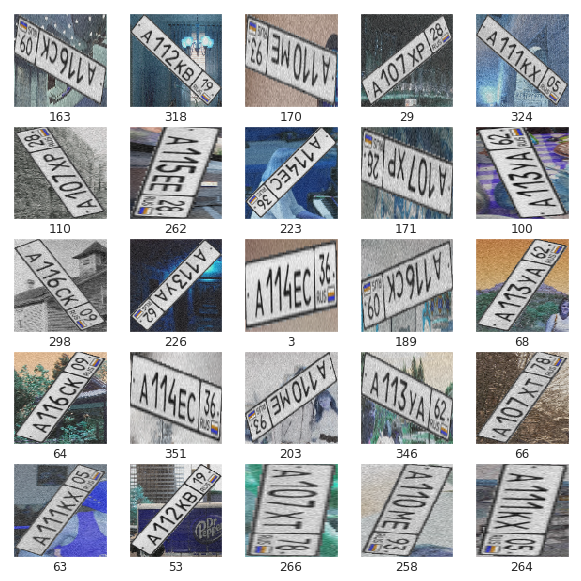

In [39]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_CI[i], cmap=plt.cm.binary)
    plt.xlabel(Y_CI[i])
plt.show()

#### Test prediction on clean imgs

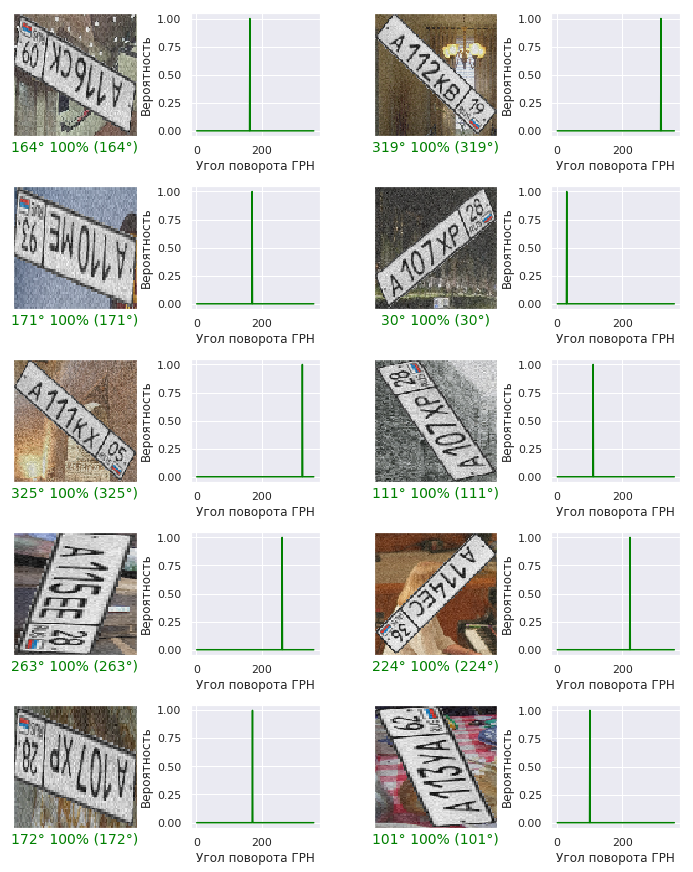

In [48]:
num_rows = 5
num_cols = 2
num_images = num_rows*num_cols
fig = plt.figure(figsize=(6*num_cols, 3*num_rows))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for idx, path in enumerate(Z_CI[:num_images]):
    prediction = loaded_model.predict(prepare_3ch(path))
    img = image.load_img(path, target_size=(100, 100))
#     fig = plt.figure(figsize=(8, 6))
    d = {"Угол поворота ГРН": CATEGORIES_INT, "Вероятность": prediction[0]}
    pdnumval = pd.DataFrame(d)
    fig.add_subplot(num_rows, 2*num_cols, 2*idx+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    predicted_label = np.argmax(prediction)
    if predicted_label == Y_CI[idx]:
        color = "green"
    else:
        color = "red"
    plt.xlabel(
            "{}\N{DEGREE SIGN} {:2.0f}% ({}\N{DEGREE SIGN})".format(
                CATEGORIES[predicted_label],
                100 * np.max(prediction),
                CATEGORIES[Y_CI[idx]],
            ),
        color = color,
        fontsize = 14
    )
    fig.add_subplot(num_rows, 2*num_cols, 2*idx+2)
    sns.set(style="darkgrid")
    sns.lineplot(x="Угол поворота ГРН", y="Вероятность", data=pdnumval, color=color)